In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def calculate_mean_std(dataset):
    data = np.concatenate([np.asarray(dataset[i][0]) for i in range(len(dataset))], axis=0)
    mean = data.mean(axis=(0, 1, 2)) / 255.0
    std = data.std(axis=(0, 1, 2)) / 255.0
    return mean, std

In [ ]:
class CIFAR10Albumentations(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
    @staticmethod
    def transform_to_float(tensor):
      # Ensure the tensor is float32
      return tensor.float()

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # Convert PIL image to numpy array
        augmented = self.transform(image=image)
        image = augmented['image']
        image_tensor = self.transform_to_float(image)
        return image_tensor, label

# Step 4: Apply Augmentation and DataLoader
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
mean, std = calculate_mean_std(train_dataset)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


transform_train = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.CoarseDropout(
        max_holes=1, max_height=16, max_width=16,
        min_holes=1, min_height=16, min_width=16,
        fill_value=mean, mask_fill_value=None
    ),
    A.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    A.Normalize(mean=mean, std=std),  # Normalization
    A.pytorch.ToTensorV2(),  # Convert to PyTorch tensor
])

transform_test = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=mean, std=std),  # Normalization
    A.pytorch.ToTensorV2(),  # Convert to PyTorch tensor
])



train_dataset_alb = CIFAR10Albumentations(train_dataset, transform_train)
test_dataset_alb = CIFAR10Albumentations(test_dataset, transform_test)

train_loader = DataLoader(train_dataset_alb, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset_alb, batch_size=128, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
mean, std

(0.4733630004850899, 0.251568925063221)

In [ ]:
image_iter = iter(train_loader)

In [ ]:
batch_data, batch_label = next(image_iter)
batch_data.shape, batch_label.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

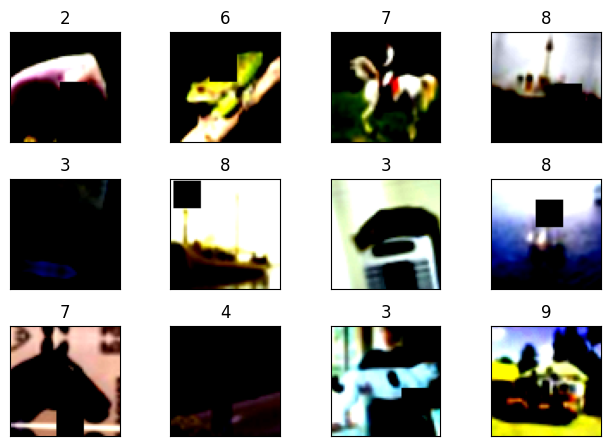

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for ele in range(12):
  batch_data, batch_label = next(image_iter)
  plt.subplot(3,4,ele+1)
  plt.tight_layout()
  plt.imshow(batch_data[ele].squeeze(0).permute(1, 2, 0))
  plt.title(batch_label[ele].item())
  plt.xticks([])
  plt.yticks([])
plt.show()

In [ ]:
type(batch_data)

torch.Tensor

In [ ]:
# Depthwise Separable Convolution Block
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, dilation = 1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, groups=in_channels, bias=bias, dilation = dilation)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block: Standard Convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False),  # Input: 1 channel -> 8 channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),  # Input: 1 channel -> 8 channels
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0, bias=False),  # Transition with stride=2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )

        # Convolution Block 1: Depthwise Separable Convolution
        self.conv2 = nn.Sequential(
            DepthwiseSeparableConv(32, 64, padding=1, bias=False),  # 8 -> 16 channels
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            DepthwiseSeparableConv(64, 64, padding=1, bias=False),  # 8 -> 16 channels
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            DepthwiseSeparableConv(64, 32, kernel_size=3, dilation=2, padding=0, bias=False),  # Transition with stride=2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )

        # Convolution Block 3: Standard Convolution with Down-sampling
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),  # Transition with stride=2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),  # Transition with stride=2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)  # Transition with stride=2
        )

        # Global Average Pooling (GAP) + Fully Connected Layer
        self.gap = nn.AdaptiveAvgPool2d(1)  # GAP reduces to 1x1
        # self.fc1 = nn.Linear(512, 256, bias=False)
        # self.fc2 = nn.Linear(64, 32, bias=False)
        self.fc3 = nn.Linear(64, 10, bias=False)  # Fully Connected Layer for 10 classes

    def forward(self, x):
      # input image size => [-1, 3, 64, 64]
      x = self.conv1(x)  # output => [-1, 16, 64, 64]
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.gap(x)    # Global Average Pooling
      x = x.view(-1, 64)
      # x = self.fc1(x)     # Fully Connected Layer
      # x = self.fc2(x)     # Fully Connected Layer
      x = self.fc3(x)     # Fully Connected Layer
      return F.log_softmax(x, dim=1)  # Output probabilities (log-softmax for classification)

#### Block 1 (conv1):
- Conv2d(3, 16, K=3, P=1, S=1):
  - R = 1 + (3 - 1) * 1 = 3
  - Jout = 1
- Conv2d(16, 32, K=3, P=1, S=1):
  - R = 3 + (3 - 1) * 1 = 5
  - Jout = 1
- Conv2d(32, 32, K=3, P=0, S=2):
  - R = 5 + (3 - 1) * 1 = 7
  - Jout = 1 * 2 = 2

#### Block 2 (conv2: Depthwise Separable):
- DepthwiseSeparableConv(32, 64, K=3, P=1, S=1):
  - R = 7 + (3 - 1) * 2 = 11
  - Jout = 2
- DepthwiseSeparableConv(64, 64, K=3, P=1, S=1):
  - R = 11 + (3 - 1) * 2 = 15
  - Jout = 2
- DepthwiseSeparableConv(64, 32, K=3, P=0, S=1, D=2):
  - Effective Kernel: K_eff = 3 + 2 * (3 - 1) = 7
  - R = 15 + (7 - 1) * 2 = 27
  - Jout = 2

#### Block 3 (conv3):
- Conv2d(32, 64, K=3, P=1, S=1):
  - R = 27 + (3 - 1) * 2 = 31
  - Jout = 2
- Conv2d(64, 64, K=3, P=1, S=1):
  - R = 31 + (3 - 1) * 2 = 35
  - Jout = 2
- Conv2d(64, 32, K=3, P=0, S=2):
  - R = 35 + (3 - 1) * 2 = 39
  - Jout = 2 * 2 = 4

#### Block 4 (conv4):
- Conv2d(32, 64, K=3, P=1, S=1):
  - R = 39 + (3 - 1) * 4 = 47
  - Jout = 4
- Conv2d(64, 64, K=3, P=1, S=1):
  - R = 47 + (3 - 1) * 4 = 55
  - Jout = 4
- Conv2d(64, 64, K=3, P=1, S=2):
  - R = 55 + (3 - 1) * 4 = 63
  - Jout = 4 * 2 = 8

| Layer                           | Rin  | Rout | Jin  | Jout |
|---------------------------------|-------|------|------|------|
| **Input Image**                 | 1     | 1    | 1    | 1    |
| **Block 1 (conv1)**             |       |      |      |      |
| Conv2d(3, 16, K=3, P=1, S=1)    | 1     | 3    | 1    | 1    |
| Conv2d(16, 32, K=3, P=1, S=1)   | 3     | 5    | 1    | 1    |
| Conv2d(32, 32, K=3, P=0, S=2)   | 5     | 7    | 1    | 2    |
| **Block 2 (conv2: Depthwise)**  |       |      |      |      |
| DepthwiseSeparableConv(K=3, P=1)| 7     | 11   | 2    | 2    |
| DepthwiseSeparableConv(K=3, P=1)| 11    | 15   | 2    | 2    |
| DepthwiseSeparableConv(K=3, D=2)| 15    | 27   | 2    | 2    |
| **Block 3 (conv3)**             |       |      |      |      |
| Conv2d(32, 64, K=3, P=1, S=1)   | 27    | 31   | 2    | 2    |
| Conv2d(64, 64, K=3, P=1, S=1)   | 31    | 35   | 2    | 2    |
| Conv2d(64, 32, K=3, P=0, S=2)   | 35    | 39   | 2    | 4    |
| **Block 4 (conv4)**             |       |      |      |      |
| Conv2d(32, 64, K=3, P=1, S=1)   | 39    | 47   | 4    | 4    |
| Conv2d(64, 64, K=3, P=1, S=1)   | 47    | 55   | 4    | 4    |
| Conv2d(64, 64, K=3, P=1, S=2)   | 55    | 63   | 4    | 8    |
| **GAP (Global Avg Pool)**       | 63    | Full | 8    | -    |


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 15, 15]           9,216
             ReLU-10           [-1, 32, 15, 15]               0
      BatchNorm2d-11           [-1, 32, 15, 15]              64
          Dropout-12           [-1, 32, 15, 15]               0
           Conv2d-13           [-1, 32, 15, 15]             288
           Conv2d-14           [-1, 64,

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion, scheduler):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = Net().to(device)
epochs = 200

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum = 0.9)
scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=4.93E-02,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=5/epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )
criterion = F.nll_loss

for epoch in range(1, epochs):
  train(model, device, train_loader, optimizer, criterion, scheduler)
  test(model, device, test_loader, criterion)
  scheduler.step()
  print(f"epoch {epoch} Done")

Train: Loss=1.5881 Batch_id=390 Accuracy=29.28: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s]


Test set: Average loss: 0.0131, Accuracy: 3836/10000 (38.36%)

epoch 1 Done


Train: Loss=1.2173 Batch_id=390 Accuracy=48.44: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]


Test set: Average loss: 0.0103, Accuracy: 5379/10000 (53.79%)

epoch 2 Done


Train: Loss=0.9397 Batch_id=390 Accuracy=56.50: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


Test set: Average loss: 0.0082, Accuracy: 6393/10000 (63.93%)

epoch 3 Done


Train: Loss=0.8118 Batch_id=390 Accuracy=60.77: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


Test set: Average loss: 0.0073, Accuracy: 6662/10000 (66.62%)

epoch 4 Done


Train: Loss=1.0094 Batch_id=390 Accuracy=63.80: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s]


Test set: Average loss: 0.0072, Accuracy: 6878/10000 (68.78%)

epoch 5 Done


Train: Loss=0.8497 Batch_id=390 Accuracy=66.27: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Test set: Average loss: 0.0066, Accuracy: 7090/10000 (70.90%)

epoch 6 Done


Train: Loss=0.9749 Batch_id=390 Accuracy=68.14: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s]


Test set: Average loss: 0.0060, Accuracy: 7322/10000 (73.22%)

epoch 7 Done


Train: Loss=0.7596 Batch_id=390 Accuracy=69.53: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]


Test set: Average loss: 0.0057, Accuracy: 7490/10000 (74.90%)

epoch 8 Done


Train: Loss=0.7559 Batch_id=390 Accuracy=71.17: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Test set: Average loss: 0.0055, Accuracy: 7620/10000 (76.20%)

epoch 9 Done


Train: Loss=0.8847 Batch_id=390 Accuracy=71.99: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Test set: Average loss: 0.0052, Accuracy: 7688/10000 (76.88%)

epoch 10 Done


Train: Loss=0.8515 Batch_id=390 Accuracy=72.99: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]


Test set: Average loss: 0.0051, Accuracy: 7766/10000 (77.66%)

epoch 11 Done


Train: Loss=0.5854 Batch_id=390 Accuracy=73.75: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]


Test set: Average loss: 0.0051, Accuracy: 7835/10000 (78.35%)

epoch 12 Done


Train: Loss=0.6805 Batch_id=390 Accuracy=74.54: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]


Test set: Average loss: 0.0049, Accuracy: 7893/10000 (78.93%)

epoch 13 Done


Train: Loss=0.8391 Batch_id=390 Accuracy=75.26: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


Test set: Average loss: 0.0047, Accuracy: 7970/10000 (79.70%)

epoch 14 Done


Train: Loss=0.7375 Batch_id=390 Accuracy=75.53: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Test set: Average loss: 0.0043, Accuracy: 8075/10000 (80.75%)

epoch 15 Done


Train: Loss=0.7402 Batch_id=390 Accuracy=76.19: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]


Test set: Average loss: 0.0046, Accuracy: 8066/10000 (80.66%)

epoch 16 Done


Train: Loss=0.7527 Batch_id=390 Accuracy=76.46: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]


Test set: Average loss: 0.0047, Accuracy: 7904/10000 (79.04%)

epoch 17 Done


Train: Loss=0.5689 Batch_id=390 Accuracy=76.90: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]


Test set: Average loss: 0.0043, Accuracy: 8174/10000 (81.74%)

epoch 18 Done


Train: Loss=0.8086 Batch_id=390 Accuracy=77.13: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


Test set: Average loss: 0.0042, Accuracy: 8197/10000 (81.97%)

epoch 19 Done


Train: Loss=0.8336 Batch_id=390 Accuracy=77.41: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]


Test set: Average loss: 0.0041, Accuracy: 8186/10000 (81.86%)

epoch 20 Done


Train: Loss=0.8874 Batch_id=390 Accuracy=78.12: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]


Test set: Average loss: 0.0041, Accuracy: 8179/10000 (81.79%)

epoch 21 Done


Train: Loss=0.6564 Batch_id=390 Accuracy=78.32: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


Test set: Average loss: 0.0040, Accuracy: 8281/10000 (82.81%)

epoch 22 Done


Train: Loss=0.6644 Batch_id=390 Accuracy=78.68: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Test set: Average loss: 0.0039, Accuracy: 8301/10000 (83.01%)

epoch 23 Done


Train: Loss=0.6439 Batch_id=390 Accuracy=78.93: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Test set: Average loss: 0.0037, Accuracy: 8392/10000 (83.92%)

epoch 24 Done


Train: Loss=0.5986 Batch_id=390 Accuracy=79.23: 100%|██████████| 391/391 [00:48<00:00,  8.03it/s]


Test set: Average loss: 0.0038, Accuracy: 8365/10000 (83.65%)

epoch 25 Done


Train: Loss=0.5954 Batch_id=390 Accuracy=79.38: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


Test set: Average loss: 0.0040, Accuracy: 8263/10000 (82.63%)

epoch 26 Done


Train: Loss=0.6682 Batch_id=390 Accuracy=79.49: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


Test set: Average loss: 0.0039, Accuracy: 8318/10000 (83.18%)

epoch 27 Done


Train: Loss=0.5935 Batch_id=390 Accuracy=79.68: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]


Test set: Average loss: 0.0038, Accuracy: 8395/10000 (83.95%)

epoch 28 Done


Train: Loss=0.6101 Batch_id=390 Accuracy=80.00: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]


Test set: Average loss: 0.0038, Accuracy: 8334/10000 (83.34%)

epoch 29 Done


Train: Loss=0.5794 Batch_id=390 Accuracy=80.26: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]


Test set: Average loss: 0.0036, Accuracy: 8433/10000 (84.33%)

epoch 30 Done


Train: Loss=0.6229 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]


Test set: Average loss: 0.0038, Accuracy: 8320/10000 (83.20%)

epoch 31 Done


Train: Loss=0.6138 Batch_id=390 Accuracy=80.47: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]


Test set: Average loss: 0.0036, Accuracy: 8403/10000 (84.03%)

epoch 32 Done


Train: Loss=0.5501 Batch_id=390 Accuracy=80.71: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


Test set: Average loss: 0.0035, Accuracy: 8507/10000 (85.07%)

epoch 33 Done


Train: Loss=0.4963 Batch_id=390 Accuracy=80.78: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


Test set: Average loss: 0.0036, Accuracy: 8419/10000 (84.19%)

epoch 34 Done


Train: Loss=0.8379 Batch_id=390 Accuracy=81.27: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]


Test set: Average loss: 0.0036, Accuracy: 8430/10000 (84.30%)

epoch 35 Done


Train: Loss=0.6178 Batch_id=390 Accuracy=81.06: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]


Test set: Average loss: 0.0034, Accuracy: 8507/10000 (85.07%)

epoch 36 Done


Train: Loss=0.2954 Batch_id=390 Accuracy=81.36: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]


Test set: Average loss: 0.0035, Accuracy: 8484/10000 (84.84%)

epoch 37 Done


Train: Loss=0.3450 Batch_id=390 Accuracy=81.56: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]


Test set: Average loss: 0.0036, Accuracy: 8432/10000 (84.32%)

epoch 38 Done


Train: Loss=0.7354 Batch_id=390 Accuracy=81.83: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]


Test set: Average loss: 0.0033, Accuracy: 8587/10000 (85.87%)

epoch 39 Done


Train: Loss=0.4864 Batch_id=390 Accuracy=81.63: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]


Test set: Average loss: 0.0035, Accuracy: 8519/10000 (85.19%)

epoch 40 Done


Train: Loss=0.4910 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [00:46<00:00,  8.39it/s]


Test set: Average loss: 0.0034, Accuracy: 8533/10000 (85.33%)

epoch 41 Done


Train: Loss=0.5102 Batch_id=390 Accuracy=81.95: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]


Test set: Average loss: 0.0034, Accuracy: 8541/10000 (85.41%)

epoch 42 Done


Train: Loss=0.4943 Batch_id=390 Accuracy=82.12: 100%|██████████| 391/391 [00:48<00:00,  8.03it/s]


Test set: Average loss: 0.0034, Accuracy: 8519/10000 (85.19%)

epoch 43 Done


Train: Loss=0.6537 Batch_id=390 Accuracy=82.06: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


Test set: Average loss: 0.0032, Accuracy: 8599/10000 (85.99%)

epoch 44 Done


Train: Loss=0.4852 Batch_id=390 Accuracy=82.49: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]


Test set: Average loss: 0.0032, Accuracy: 8619/10000 (86.19%)

epoch 45 Done


Train: Loss=0.6475 Batch_id=390 Accuracy=82.40: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


Test set: Average loss: 0.0034, Accuracy: 8580/10000 (85.80%)

epoch 46 Done


Train: Loss=0.4377 Batch_id=390 Accuracy=82.80: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


Test set: Average loss: 0.0035, Accuracy: 8516/10000 (85.16%)

epoch 47 Done


Train: Loss=0.3651 Batch_id=390 Accuracy=82.78: 100%|██████████| 391/391 [00:49<00:00,  7.91it/s]


Test set: Average loss: 0.0031, Accuracy: 8640/10000 (86.40%)

epoch 48 Done


Train: Loss=0.3760 Batch_id=390 Accuracy=82.94: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]


Test set: Average loss: 0.0035, Accuracy: 8468/10000 (84.68%)

epoch 49 Done


Train: Loss=0.3763 Batch_id=390 Accuracy=82.96: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


Test set: Average loss: 0.0034, Accuracy: 8509/10000 (85.09%)

epoch 50 Done


Train: Loss=0.3983 Batch_id=390 Accuracy=82.76: 100%|██████████| 391/391 [00:49<00:00,  7.98it/s]


Test set: Average loss: 0.0032, Accuracy: 8634/10000 (86.34%)

epoch 51 Done


Train: Loss=0.4414 Batch_id=390 Accuracy=83.12: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]


Test set: Average loss: 0.0032, Accuracy: 8646/10000 (86.46%)

epoch 52 Done


Train: Loss=0.4402 Batch_id=390 Accuracy=83.20: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


Test set: Average loss: 0.0031, Accuracy: 8667/10000 (86.67%)

epoch 53 Done


Train: Loss=0.4438 Batch_id=390 Accuracy=83.26: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]


Test set: Average loss: 0.0033, Accuracy: 8572/10000 (85.72%)

epoch 54 Done


Train: Loss=0.5656 Batch_id=390 Accuracy=83.43: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


Test set: Average loss: 0.0031, Accuracy: 8640/10000 (86.40%)

epoch 55 Done


Train: Loss=0.5203 Batch_id=390 Accuracy=83.28: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]


Test set: Average loss: 0.0031, Accuracy: 8709/10000 (87.09%)

epoch 56 Done


Train: Loss=0.4969 Batch_id=390 Accuracy=83.41: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


Test set: Average loss: 0.0033, Accuracy: 8579/10000 (85.79%)

epoch 57 Done


Train: Loss=0.5919 Batch_id=390 Accuracy=83.55: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]


Test set: Average loss: 0.0031, Accuracy: 8679/10000 (86.79%)

epoch 58 Done


Train: Loss=0.5583 Batch_id=390 Accuracy=83.68: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]


Test set: Average loss: 0.0032, Accuracy: 8616/10000 (86.16%)

epoch 59 Done


Train: Loss=0.5612 Batch_id=390 Accuracy=83.59: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Test set: Average loss: 0.0030, Accuracy: 8676/10000 (86.76%)

epoch 60 Done


Train: Loss=0.3246 Batch_id=390 Accuracy=83.86: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]


Test set: Average loss: 0.0032, Accuracy: 8602/10000 (86.02%)

epoch 61 Done


Train: Loss=0.4320 Batch_id=390 Accuracy=83.74: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


Test set: Average loss: 0.0030, Accuracy: 8675/10000 (86.75%)

epoch 62 Done


Train: Loss=0.5722 Batch_id=390 Accuracy=83.92: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]


Test set: Average loss: 0.0031, Accuracy: 8629/10000 (86.29%)

epoch 63 Done


Train: Loss=0.2096 Batch_id=390 Accuracy=83.96: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]


Test set: Average loss: 0.0030, Accuracy: 8708/10000 (87.08%)

epoch 64 Done


Train: Loss=0.3814 Batch_id=390 Accuracy=83.94: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


Test set: Average loss: 0.0031, Accuracy: 8653/10000 (86.53%)

epoch 65 Done


Train: Loss=0.5244 Batch_id=390 Accuracy=84.01: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


Test set: Average loss: 0.0030, Accuracy: 8686/10000 (86.86%)

epoch 66 Done


Train: Loss=0.5006 Batch_id=390 Accuracy=84.17: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]


Test set: Average loss: 0.0031, Accuracy: 8726/10000 (87.26%)

epoch 67 Done


Train: Loss=0.4367 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:48<00:00,  8.03it/s]


Test set: Average loss: 0.0029, Accuracy: 8749/10000 (87.49%)

epoch 68 Done


Train: Loss=0.4551 Batch_id=390 Accuracy=84.27: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


Test set: Average loss: 0.0029, Accuracy: 8716/10000 (87.16%)

epoch 69 Done


Train: Loss=0.4999 Batch_id=390 Accuracy=84.48: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


Test set: Average loss: 0.0030, Accuracy: 8713/10000 (87.13%)

epoch 70 Done


Train: Loss=0.4139 Batch_id=390 Accuracy=84.53: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]


Test set: Average loss: 0.0029, Accuracy: 8740/10000 (87.40%)

epoch 71 Done


Train: Loss=0.4256 Batch_id=390 Accuracy=84.48: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


Test set: Average loss: 0.0030, Accuracy: 8692/10000 (86.92%)

epoch 72 Done


Train: Loss=0.3319 Batch_id=390 Accuracy=84.87: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]


Test set: Average loss: 0.0030, Accuracy: 8713/10000 (87.13%)

epoch 73 Done


Train: Loss=0.4232 Batch_id=390 Accuracy=84.60: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]


Test set: Average loss: 0.0031, Accuracy: 8667/10000 (86.67%)

epoch 74 Done


Train: Loss=0.3724 Batch_id=390 Accuracy=84.44: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]


Test set: Average loss: 0.0030, Accuracy: 8736/10000 (87.36%)

epoch 75 Done


Train: Loss=0.5104 Batch_id=390 Accuracy=85.01: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]


Test set: Average loss: 0.0029, Accuracy: 8753/10000 (87.53%)

epoch 76 Done


Train: Loss=0.5663 Batch_id=390 Accuracy=84.92: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]


Test set: Average loss: 0.0029, Accuracy: 8732/10000 (87.32%)

epoch 77 Done


Train: Loss=0.6884 Batch_id=390 Accuracy=85.05: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]


Test set: Average loss: 0.0029, Accuracy: 8773/10000 (87.73%)

epoch 78 Done


Train: Loss=0.3174 Batch_id=390 Accuracy=84.98: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]


Test set: Average loss: 0.0029, Accuracy: 8724/10000 (87.24%)

epoch 79 Done


Train: Loss=0.5122 Batch_id=390 Accuracy=84.92: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s]


Test set: Average loss: 0.0029, Accuracy: 8782/10000 (87.82%)

epoch 80 Done


Train: Loss=0.2865 Batch_id=390 Accuracy=85.04: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


Test set: Average loss: 0.0028, Accuracy: 8775/10000 (87.75%)

epoch 81 Done


Train: Loss=0.3676 Batch_id=390 Accuracy=85.02: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


Test set: Average loss: 0.0028, Accuracy: 8770/10000 (87.70%)

epoch 82 Done


Train: Loss=0.4973 Batch_id=390 Accuracy=85.22: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


Test set: Average loss: 0.0030, Accuracy: 8727/10000 (87.27%)

epoch 83 Done


Train: Loss=0.4860 Batch_id=390 Accuracy=85.23: 100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


Test set: Average loss: 0.0029, Accuracy: 8756/10000 (87.56%)

epoch 84 Done


Train: Loss=0.3688 Batch_id=390 Accuracy=85.14: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]


Test set: Average loss: 0.0030, Accuracy: 8671/10000 (86.71%)

epoch 85 Done


Train: Loss=0.3757 Batch_id=390 Accuracy=85.25: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


Test set: Average loss: 0.0028, Accuracy: 8771/10000 (87.71%)

epoch 86 Done


Train: Loss=0.5745 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Test set: Average loss: 0.0029, Accuracy: 8721/10000 (87.21%)

epoch 87 Done


Train: Loss=0.3990 Batch_id=260 Accuracy=85.41:  67%|██████▋   | 261/391 [00:33<00:14,  8.87it/s]